@misc{chollet2015keras,
  title={Keras},
  author={Chollet, Fran\c{c}ois and others},
  year={2015},
  howpublished={\url{https://keras.io}},
}

In [8]:
### In this Pointnet approach we go over the attempts we tried until we finally reached good results at the end.




# Reading point cloud data, preprocessing it, and preparing it for classification. 
# For each class, it randomly selects a certain number of files, loads point cloud data from each file, 
# and downsamples the data to a specified number of points.
# If the loaded point cloud has fewer points than the desired amount, padding is added with zeros. 
# The resulting point cloud data and corresponding class labels are stored in the data and labels arrays. 
# The code then prints the shape of the loaded data and the shape of a  single training image (point cloud). 
# This code prepares the data for training a machine learning model on the downsampled point cloud data.


import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the classes in your dataset
classes = ['2lanes', '3lanes', 'crossing', 'split4lanes', 'split6lanes', 'transition']

# Path to your dataset directory
DATASET_DIR = 'dataset'

# Define the number of points you want to downsample to
num_points_per_cloud = 2048
# Number of files to take from each subfolder (class)
files_per_class = 130

# Load and preprocess the data
data = []
labels = []

for class_index, class_name in enumerate(classes):
    folder_path = os.path.join(DATASET_DIR, class_name)
    file_names = os.listdir(folder_path)
    
    # Randomly select files from the class folder
    selected_files = np.random.choice(file_names, files_per_class, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(folder_path, file_name)
        # Load point cloud data from .npy file
        point_data = np.load(file_path, allow_pickle=True)
        
        # Downsample to the desired number of points
        if len(point_data) > 2048:
            selected_indices = np.random.choice(len(point_data), 2048, replace=False)
            point_data = point_data[selected_indices]
        elif len(point_data) < 2048:
            padding_size = 2048 - len(point_data)
            point_data = np.vstack((point_data, np.zeros((padding_size, point_data.shape[1]))))
        
        data.append(point_data)
        labels.append(class_index)

data = np.array(data)
labels = np.array(labels)



print("Data Shape:", len(data))

print("labels Shape:", len(labels))


print("Shape of a Training Image:", data[17].shape)  # this is just for any single image to check its size 


Data Shape: 780
labels Shape: 780
Shape of a Training Image: (2048, 22)


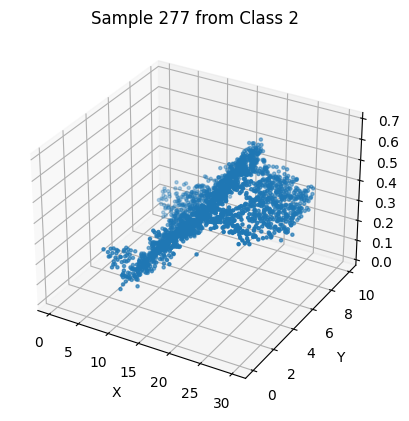

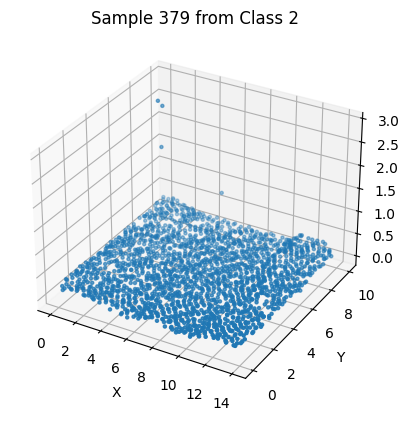

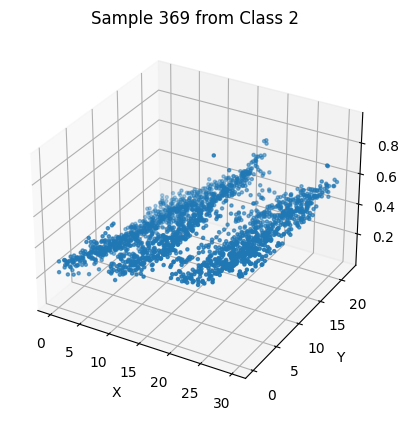

In [9]:
# Visualize Some Samples


# Choose a class to visualize
class_index_to_visualize = 2

# Find indices of samples from the chosen class
class_indices = np.where(labels == class_index_to_visualize)[0]

# Randomly select a few samples from the chosen class
num_samples_to_visualize = 3
selected_indices = np.random.choice(class_indices, num_samples_to_visualize, replace=False)

# Create a 3D scatter plot for each selected sample
for sample_index in selected_indices:
    # Retrieve the point cloud data for the sample
    sample_data = data[sample_index]
    
    # Extract x, y, z coordinates from the point cloud data
    x_coords = sample_data[:, 0]
    y_coords = sample_data[:, 1]
    z_coords = sample_data[:, 2]
    
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_coords, y_coords, z_coords, s=5)
    ax.set_title(f"Sample {sample_index} from Class {class_index_to_visualize}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

plt.show()



In [79]:
# A complete pipeline for building, training, and evaluating a neural network model for point cloud classification  using the PointNet 
# architecture by using the first 3 features (local x,y,z).


import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dense, Dropout

# Define the classes in your dataset
classes = ['2lanes', '3lanes', 'crossing', 'split4lanes', 'split6lanes', 'transition']

# Path to your dataset directory
DATASET_DIR = 'dataset'

# Define the number of points you want to downsample to
2048 = 2048
# Number of files to take from each subfolder (class)
files_per_class = 100

# Selected features indices from your data
selected_feature_indices = [0, 1, 2, 9, 15, 16]

# Load and preprocess the data
data = []
labels = []

for class_index, class_name in enumerate(classes):
    folder_path = os.path.join(DATASET_DIR, class_name)
    file_names = os.listdir(folder_path)
    
    selected_files = np.random.choice(file_names, files_per_class, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(folder_path, file_name)
        point_data = np.load(file_path, allow_pickle=True)
        
        selected_features = point_data[:, selected_feature_indices]
        
        if len(selected_features) > num_points_per_cloud:
            selected_indices = np.random.choice(len(selected_features), num_points_per_cloud, replace=False)
            selected_features = selected_features[selected_indices]
        elif len(selected_features) < num_points_per_cloud:
            padding_size = num_points_per_cloud - len(selected_features)
            selected_features = np.vstack((selected_features, np.zeros((padding_size, selected_features.shape[1]))))
        
        data.append(selected_features)
        labels.append(class_index)

data = np.array(data)
labels = np.array(labels)

# Split the dataset into training and testing sets
test_size = 0.2
random_seed = 42
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=test_size, random_state=random_seed)

# Build the PointNet model
model = models.Sequential()
model.add(layers.Input(shape=(num_points_per_cloud, len(selected_feature_indices))))
model.add(BatchNormalization())
model.add(Conv1D(64, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(128, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(256, 1, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(512, 1, activation='relu'))
model.add(BatchNormalization())
model.add(Conv1D(1024, 1, activation='relu'))
model.add(BatchNormalization())
model.add(GlobalMaxPooling1D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels, batch_size=32, epochs=20, validation_split=0.1)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_acc}")


Epoch 1/20
14/14 [==============================] - 22s 1s/step - loss: 8.0737 - accuracy: 0.1667 - val_loss: 1.8608 - val_accuracy: 0.1042
Epoch 2/20
14/14 [==============================] - 20s 1s/step - loss: 3.6062 - accuracy: 0.2222 - val_loss: 1.8073 - val_accuracy: 0.1875
Epoch 3/20
14/14 [==============================] - 20s 1s/step - loss: 2.0462 - accuracy: 0.3009 - val_loss: 1.7894 - val_accuracy: 0.1458
Epoch 4/20
14/14 [==============================] - 20s 1s/step - loss: 1.7468 - accuracy: 0.3009 - val_loss: 1.7850 - val_accuracy: 0.2708
Epoch 5/20
14/14 [==============================] - 19s 1s/step - loss: 1.6796 - accuracy: 0.3194 - val_loss: 1.7725 - val_accuracy: 0.1667
Epoch 6/20
14/14 [==============================] - 19s 1s/step - loss: 1.6055 - accuracy: 0.3472 - val_loss: 1.7659 - val_accuracy: 0.2917
Epoch 7/20
14/14 [==============================] - 19s 1s/step - loss: 1.5829 - accuracy: 0.3542 - val_loss: 1.7479 - val_accuracy: 0.2917
Epoch 8/20
14/14 [==

In [10]:
# # # Since the Test accuracy: 0.449,  This code provided is an extension and enhancement of the earlier code, 
# with the primary goal of preparing the data and creating TensorFlow datasets for training and testing, while also incorporating data augmentation. 
# Here's a breakdown of the key differences and improvements in the new code:

# # 1. **Data Augmentation:** The new code includes a data augmentation step, which modifies the input point clouds slightly to introduce variation during training. This helps the model generalize better to unseen data. The earlier code did not include data augmentation.

# # 2. **Use of TensorFlow:** The new code leverages TensorFlow's capabilities for creating and manipulating datasets efficiently. It uses TensorFlow's data pipeline functions to shuffle, batch, and apply augmentation to the datasets. This approach provides better performance and integration with TensorFlow's training procedures.

# # 3. **Conversion to TensorFlow Tensors:** The new code converts the data and labels into TensorFlow tensors before creating datasets. This aligns with TensorFlow's data handling and allows better integration with the TensorFlow framework.

# # 4. **Modular Functionality:** The new code separates data augmentation logic into a separate function, making the code more modular and easier to understand.

# # 5. **Consistency and Best Practices:** The new code follows TensorFlow best practices for data handling and augmentation, improving readability and maintainability.

# # Overall, the new code is more comprehensive, efficient, and aligned with TensorFlow's data handling mechanisms, providing better support for training neural network models on point cloud data.

import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the classes in your dataset
classes = ['2lanes', '3lanes', 'crossing', 'split4lanes', 'split6lanes', 'transition']

# Path to your dataset directory
DATASET_DIR = 'dataset'

# Define the number of points you want to downsample to
num_points_per_cloud = 2048
# Number of files to take from each subfolder (class)
files_per_class = 130

# Load and preprocess the data
data = []
labels = []

for class_index, class_name in enumerate(classes):
    folder_path = os.path.join(DATASET_DIR, class_name)
    file_names = os.listdir(folder_path)
    
    # Randomly select files from the class folder
    selected_files = np.random.choice(file_names, files_per_class, replace=False)
    
    for file_name in selected_files:
        file_path = os.path.join(folder_path, file_name)
        # Load point cloud data from .npy file
        point_data = np.load(file_path, allow_pickle=True)
        
        # Take the first 3 features (local x, local y, local z)
        point_data = point_data[:, :3]
        
        # Downsample to the desired number of points
        if len(point_data) > num_points_per_cloud:
            selected_indices = np.random.choice(len(point_data), num_points_per_cloud, replace=False)
            point_data = point_data[selected_indices]
        elif len(point_data) < num_points_per_cloud:
            padding_size = num_points_per_cloud - len(point_data)
            point_data = np.vstack((point_data, np.zeros((padding_size, point_data.shape[1]))))
        
        data.append(point_data)
        labels.append(class_index)

data = np.array(data)
labels = np.array(labels)

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert the data to TensorFlow tensors
train_points = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_points = tf.convert_to_tensor(test_data, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Define the batch size
BATCH_SIZE = 32

# Define the function for data augmentation
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

# Apply data augmentation to the training dataset
train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)

# Leave the test dataset as it is (no augmentation)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)



In [11]:

###  Construction of the PointNet architecture for point cloud classification, including its specific layers and custom components.

import os
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, initializers

# Define the function for convolutional layer with batch normalization and ReLU activation
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# Define the function for fully connected layer with batch normalization and ReLU activation
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

# Define the OrthogonalRegularizer class
class OrthogonalRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

# Define the tnet function
def tnet(inputs, num_features):
    # Initialize bias as the identity matrix
    bias = initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

# Define the PointNet architecture
def build_pointnet_model(num_points, num_classes):
    inputs = tf.keras.Input(shape=(num_points, 3))

    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
    return model

# ... (data loading and preprocessing)

NUM_POINTS = num_points_per_cloud
NUM_CLASSES = len(classes)

# Convert the data to TensorFlow tensors
train_points = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_points = tf.convert_to_tensor(test_data, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

# Apply data augmentation to the training dataset
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float32)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

# Build the PointNet model
model = build_pointnet_model(NUM_POINTS, NUM_CLASSES)
model.summary()

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 2048, 3)]            0         []                            
                                                                                                  
 conv1d_22 (Conv1D)          (None, 2048, 32)             128       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_34 (Ba  (None, 2048, 32)             128       ['conv1d_22[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_34 (Activation)  (None, 2048, 32)             0         ['batch_normalization_3

In [13]:
#### Let us compile 

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
20/20 [==============================] - 54s 2s/step - loss: 3.6499 - sparse_categorical_accuracy: 0.2692 - val_loss: 78.6117 - val_sparse_categorical_accuracy: 0.2949
Epoch 2/20
20/20 [==============================] - 38s 2s/step - loss: 2.9543 - sparse_categorical_accuracy: 0.3317 - val_loss: 2.9288 - val_sparse_categorical_accuracy: 0.3718
Epoch 3/20
20/20 [==============================] - 39s 2s/step - loss: 2.8411 - sparse_categorical_accuracy: 0.3478 - val_loss: 3.4415 - val_sparse_categorical_accuracy: 0.3782
Epoch 4/20
20/20 [==============================] - 39s 2s/step - loss: 2.7001 - sparse_categorical_accuracy: 0.3958 - val_loss: 3.2534 - val_sparse_categorical_accuracy: 0.4103
Epoch 5/20
20/20 [==============================] - 39s 2s/step - loss: 2.7093 - sparse_categorical_accuracy: 0.3590 - val_loss: 33354.7500 - val_sparse_categorical_accuracy: 0.3013
Epoch 6/20
20/20 [==============================] - 39s 2s/step - loss: 2.6781 - sparse_categorical_accur

In [13]:
## it seems we still couldn't get a good accuracy. Now let us combine all the knowledge we learned and use 6 Channels this time which are the local x,y,z, and colors r,g,b


import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, initializers

classes = ['2lanes', '3lanes', 'crossing', 'split4lanes', 'split6lanes', 'transition']
DATASET_DIR = 'dataset'
num_points_per_cloud = 2048
files_per_class = 133

data = []
labels = []
# Combine and preprocess the data
for class_index, class_name in enumerate(classes):
    folder_path = os.path.join(DATASET_DIR, class_name)
    file_names = os.listdir(folder_path)
    selected_files = np.random.choice(file_names, files_per_class, replace=False)
    for file_name in selected_files:
        file_path = os.path.join(folder_path, file_name)
        point_data = np.load(file_path, allow_pickle=True)
        local_coords = point_data[:, :3]
        rgb_values = point_data[:, 3:6]
        if len(point_data) > num_points_per_cloud:
            selected_indices = np.random.choice(len(point_data), num_points_per_cloud, replace=False)
            point_data = point_data[selected_indices]
        elif len(point_data) < num_points_per_cloud:
            padding_size = num_points_per_cloud - len(point_data)
            point_data = np.vstack((point_data, np.zeros((padding_size, point_data.shape[1]))))
        combined_data = np.concatenate((local_coords, rgb_values), axis=1)
        
        # Pad or truncate combined_data to ensure consistent shape
        if combined_data.shape[0] < num_points_per_cloud:
            padding_size = num_points_per_cloud - combined_data.shape[0]
            combined_data = np.vstack((combined_data, np.zeros((padding_size, combined_data.shape[1]))))
        elif combined_data.shape[0] > num_points_per_cloud:
            combined_data = combined_data[:num_points_per_cloud, :]
        
        data.append(combined_data)
        labels.append(class_index)

train_data = np.array(data)
train_labels = np.array(labels)

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Convert data arrays to TensorFlow tensors
train_points = tf.convert_to_tensor(train_data, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)

test_points = tf.convert_to_tensor(test_data, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)


# Print shapes for debugging
print("Train Data Shape:", train_points.shape)
print("Test Data Shape:", test_points.shape)
print("Train Labels Shape:", train_labels.shape)  # Corrected line
print("Test Labels Shape:", test_labels.shape)    # Added line for test_labels


Train Data Shape: (638, 2048, 6)
Test Data Shape: (160, 2048, 6)
Train Labels Shape: (638,)
Test Labels Shape: (160,)


In [130]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout

def pointnet_model(num_points, num_channels, num_classes):
    input_points = Input(shape=(num_points, num_channels))
    
    # Shared Multi-Layer Perceptron (MLP) applied to each point
    x = Conv1D(64, 1, activation='relu')(input_points)
    x = Conv1D(128, 1, activation='relu')(x)
    x = Conv1D(1024, 1, activation='relu')(x)
    
    # Max pooling across all points
    x = MaxPooling1D(num_points)(x)
    
    # Global features
    x = Flatten()(x)
    
    # MLP for classification
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_points, outputs=x)
    return model

# Parameters
num_points_per_cloud = 2048
num_channels = 6  # 3 for local coordinates, 3 for RGB values
num_classes = len(classes)  # Number of classes in your classification task

# Instantiate the PointNet model
model = pointnet_model(num_points_per_cloud, num_channels, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_points, train_labels, validation_data=(test_points, test_labels), epochs=100, batch_size=64)


Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 9.6451 - accuracy: 0.1554 - val_loss: 2.8323 - val_accuracy: 0.1795
Epoch 2/100
10/10 [==============================] - 10s 1s/step - loss: 2.7607 - accuracy: 0.1827 - val_loss: 1.8846 - val_accuracy: 0.1667
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 1.9898 - accuracy: 0.1763 - val_loss: 1.7997 - val_accuracy: 0.2051
Epoch 4/100
10/10 [==============================] - 10s 1s/step - loss: 1.8635 - accuracy: 0.1683 - val_loss: 1.7926 - val_accuracy: 0.1923
Epoch 5/100
10/10 [==============================] - 11s 1s/step - loss: 1.8091 - accuracy: 0.1554 - val_loss: 1.7770 - val_accuracy: 0.1923
Epoch 6/100
10/10 [==============================] - 11s 1s/step - loss: 1.7922 - accuracy: 0.1811 - val_loss: 1.7689 - val_accuracy: 0.2244
Epoch 7/100
10/10 [==============================] - 10s 1s/step - loss: 1.7751 - accuracy: 0.1939 - val_loss: 1.7586 - val_accuracy: 0.2756
Epoch 8/100
1

5/5 [==============================] - 1s 101ms/step


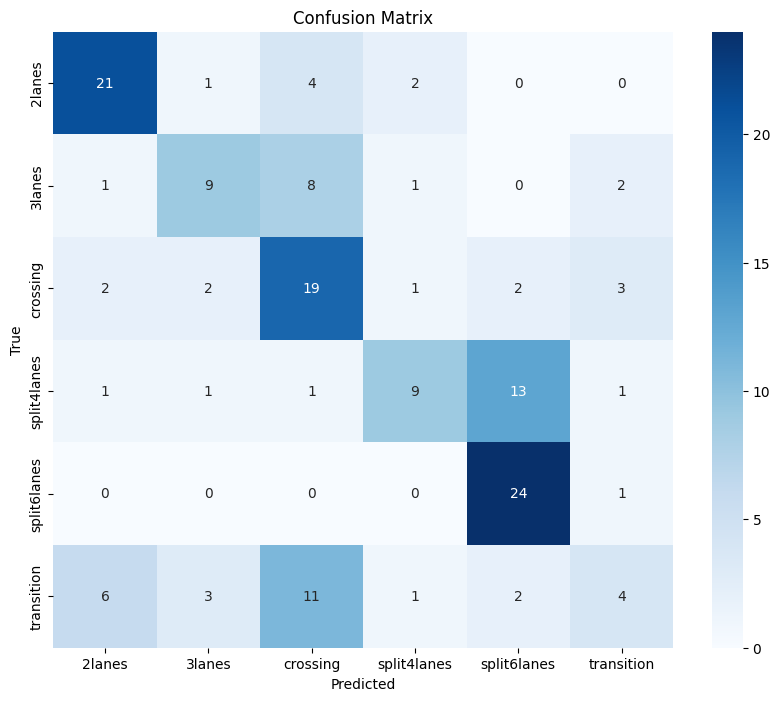

Overall Accuracy: 0.5512820512820513


In [131]:
# Evaluate and visualize results

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the trained model
predictions = model.predict(test_points)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


from sklearn.metrics import accuracy_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, predicted_labels)
print("Overall Accuracy:", overall_accuracy)


In [7]:
## Now let us use the Preprocessed Dataset which we obtained from Preprocessing_PointClouds.ipynb and see the difference in accuracy ##

## Now let us use the Preprocessed Dataset which we obtained from Preprocessing_PointClouds.ipynb and see the difference in accuracy ##

## Now let us use the Preprocessed Dataset which we obtained from Preprocessing_PointClouds.ipynb and see the difference in accuracy ##


import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

classes = ['2lanes', '3lanes', 'crossing', 'split4lanes', 'split6lanes', 'transition']
DATASET_DIR = 'processed_pointclouds'
num_points_per_cloud = 2048
files_per_class = 500

data = []
labels = []

# Combine and preprocess the data
for class_index, class_name in enumerate(classes):
    folder_path = os.path.join(DATASET_DIR, class_name)
    file_names = os.listdir(folder_path)
    selected_files = np.random.choice(file_names, files_per_class, replace=False)
    for file_name in selected_files:
        file_path = os.path.join(folder_path, file_name)
        point_data = np.load(file_path, allow_pickle=True)
        local_coords = point_data[:, :3]
        rgb_values = point_data[:, 3:6]
        
        if len(point_data) > num_points_per_cloud:
            selected_indices = np.random.choice(len(point_data), num_points_per_cloud, replace=False)
            point_data = point_data[selected_indices]
        elif len(point_data) < num_points_per_cloud:
            padding_size = num_points_per_cloud - len(point_data)
            point_data = np.vstack((point_data, np.zeros((padding_size, point_data.shape[1]))))
        
        combined_data = np.concatenate((local_coords, rgb_values), axis=1)
        
        # Pad or truncate combined_data to ensure consistent shape
        if combined_data.shape[0] < num_points_per_cloud:
            padding_size = num_points_per_cloud - combined_data.shape[0]
            combined_data = np.vstack((combined_data, np.zeros((padding_size, combined_data.shape[1]))))
        elif combined_data.shape[0] > num_points_per_cloud:
            combined_data = combined_data[:num_points_per_cloud, :]
        
        data.append(combined_data)
        labels.append(class_index)

train_data = np.array(data)
train_labels = np.array(labels)

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Convert data arrays to TensorFlow tensors
train_points = tf.convert_to_tensor(train_data, dtype=tf.float32)
train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)

test_points = tf.convert_to_tensor(test_data, dtype=tf.float32)
test_labels = tf.convert_to_tensor(test_labels, dtype=tf.int32)

# Print shapes for debugging
print("Train Data Shape:", train_points.shape)
print("Test Data Shape:", test_points.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Labels Shape:", test_labels.shape)


Train Data Shape: (2400, 2048, 6)
Test Data Shape: (600, 2048, 6)
Train Labels Shape: (2400,)
Test Labels Shape: (600,)


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Flatten, Dropout

def pointnet_model(num_points, num_channels, num_classes):
    input_points = Input(shape=(num_points, num_channels))
    
    # Shared Multi-Layer Perceptron (MLP) applied to each point
    x = Conv1D(64, 1, activation='relu')(input_points)
    x = Conv1D(128, 1, activation='relu')(x)
    x = Conv1D(1024, 1, activation='relu')(x)
    
    # Max pooling across all points
    x = MaxPooling1D(num_points)(x)
    
    # Global features
    x = Flatten()(x)
    
    # MLP for classification
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_points, outputs=x)
    return model

# Parameters
num_points_per_cloud = 2048
num_channels = 6  # 3 for local coordinates, 3 for RGB values
num_classes = len(classes)  # Number of classes in your classification task

# Instantiate the PointNet model
model = pointnet_model(num_points_per_cloud, num_channels, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_points, train_labels, validation_data=(test_points, test_labels), epochs=100, batch_size=64)


Epoch 1/100
38/38 [==============================] - 40s 1s/step - loss: 5.0052 - accuracy: 0.1654 - val_loss: 1.6975 - val_accuracy: 0.3933
Epoch 2/100
38/38 [==============================] - 39s 1s/step - loss: 1.6054 - accuracy: 0.3067 - val_loss: 1.3881 - val_accuracy: 0.5317
Epoch 3/100
38/38 [==============================] - 39s 1s/step - loss: 1.4361 - accuracy: 0.3787 - val_loss: 1.2195 - val_accuracy: 0.6750
Epoch 4/100
38/38 [==============================] - 39s 1s/step - loss: 1.2816 - accuracy: 0.4875 - val_loss: 1.1225 - val_accuracy: 0.6950
Epoch 5/100
38/38 [==============================] - 39s 1s/step - loss: 1.1213 - accuracy: 0.5867 - val_loss: 0.8213 - val_accuracy: 0.7600
Epoch 6/100
38/38 [==============================] - 39s 1s/step - loss: 0.9940 - accuracy: 0.6538 - val_loss: 0.7932 - val_accuracy: 0.7350
Epoch 7/100
38/38 [==============================] - 40s 1s/step - loss: 0.9693 - accuracy: 0.6475 - val_loss: 0.7282 - val_accuracy: 0.7400
Epoch 8/100
3

19/19 [==============================] - 2s 101ms/step


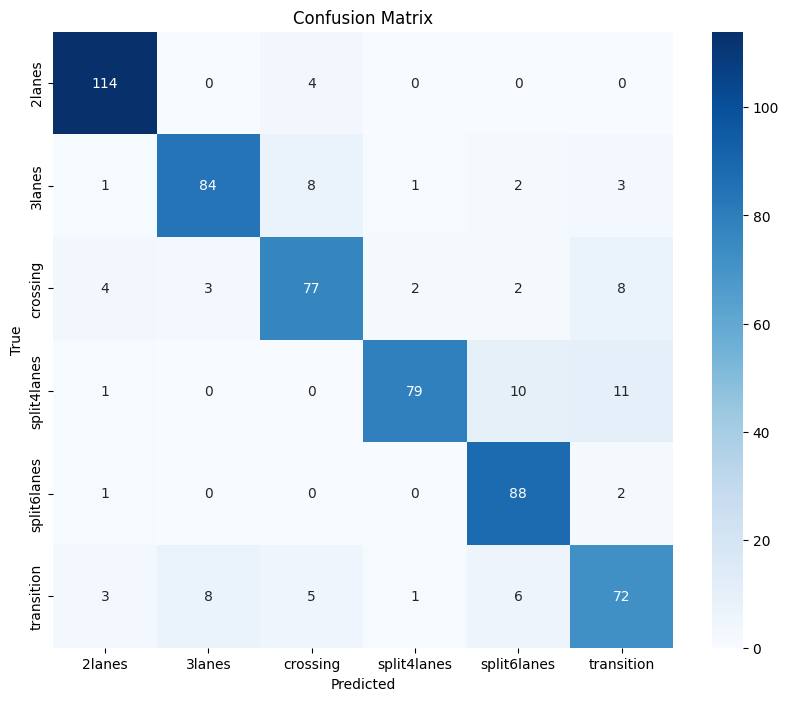

Overall Accuracy: 0.8566666666666667


In [12]:
# Evaluate and Visualize Results


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Make predictions using the trained model
predictions = model.predict(test_points)
predicted_labels = np.argmax(predictions, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


from sklearn.metrics import accuracy_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(test_labels, predicted_labels)
print("Overall Accuracy:", overall_accuracy)


In [ ]:
# As we can see, we obtained Overall Accuracy: 0.8566666666666667 using the preprocessed dataset

# Classification Report:

from sklearn.metrics import classification_report

class_report = classification_report(test_labels, predicted_labels, target_names=classes)
print(class_report)


In [ ]:
# Precision-Recall Curves:

from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_labels, predicted_labels)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


In [ ]:
# Visualizing Misclassified Samples:

misclassified_indices = np.where(test_labels != predicted_labels)[0]
num_samples_to_visualize = min(10, len(misclassified_indices))

plt.figure(figsize=(15, 8))
for i, index in enumerate(misclassified_indices[:num_samples_to_visualize]):
    ax = plt.subplot(2, num_samples_to_visualize, i + 1)
    ax.scatter(test_points[index, :, 0], test_points[index, :, 1], c='red')
    ax.set_title('True: {}\nPredicted: {}'.format(classes[test_labels[index]], classes[predicted_labels[index]]))
    ax.set_axis_off()

plt.tight_layout()
plt.show()
